# 2 Nearest Neighbor Classification on Real Data

## 2.1 Exploring the Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import scipy.stats as stats

from IPython.display import display
from vdom.helpers import h3, h4, p, b, div

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

<div />

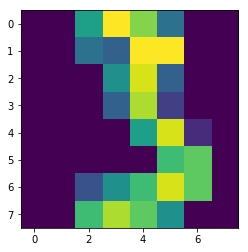

In [2]:
digits = load_digits()

data = digits['data']
images = digits['images']
target = digits['target']
target_names = digits['target_names']

display(
    div(
        p(b('dtype: '), str(data.dtype)),
        p(b('shape: '), str(data.shape)),
        p(b('targets: '), str(target))
    )
)

img = data[target == 3][3]
img.shape = 8, 8
plt.imshow(img, interpolation='nearest')
plt.show()

data_train, data_test, target_train, target_test = train_test_split(
    data, target, test_size=0.4 , random_state=0
) 

## 2.2 Distance Function Computation Using Loops

In [3]:
def dist_loop(training, test):
    distances = np.empty((
        training.shape[0],
        test.shape[0]
    ))
    
    for i, x in enumerate(training):
        for j, y in enumerate(test):
            distances[i][j] = np.sqrt(np.sum(
                    np.square(x - y) 
            ))
           
    return distances

## 2.3 Distance Function Computation Using Vectorization

In [4]:
def dist_vec(training, test):
    return np.sqrt(
        np.sum(
            np.square(
                training[:, np.newaxis, :] - test
            ), axis=2
        )
    )

In [5]:
a = dist_vec(data_train, data_test)
b = dist_loop(data_train, data_test)
np.testing.assert_array_equal(a,b)

In [6]:
display(
    h3("Time for vectorized function")
)
%timeit dist_vec(data_train, data_test)

display(
    h3("Time for loop function")
)
%timeit dist_loop(data_train, data_test)

<h3 />

173 ms ± 6.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<h3 />

3.78 s ± 67.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 2.4 Nearest Neighbor Classifier

In [7]:
def nn_classifier(data, train, target):
    return target[np.argmin(dist_vec(train, data), axis=0)]

def error_rate(x0, x1):
    mask_test = np.logical_or(target_test == x0, target_test == x1)
    mask_train = np.logical_or(target_train == x0, target_train == x1)
    return (nn_classifier(
        data_test[mask_test],
        data_train[mask_train],
        target_train[mask_train]
    ) != target_test[mask_test]).sum()/mask_test.sum()

display(
    p('1 and 3: ', str(error_rate(1, 3))),
    p('1 and 7: ', str(error_rate(1, 7))),
    p('1 and 8: ', str(error_rate(1, 8))),
    p('3 and 5: ', str(error_rate(3, 5))),
    p('3 and 8: ', str(error_rate(3, 8))),
    p('3 and 9: ', str(error_rate(3, 9))),
    p('5 and 6: ', str(error_rate(5, 6))),
    p('5 and 9: ', str(error_rate(5, 9))),
    p('8 and 9: ', str(error_rate(8, 9)))
)

<p />

<p />

<p />

<p />

<p />

<p />

<p />

<p />

<p />

## 2.5 k-Nearest Neighbor

In [8]:
def knn_classifier(k, data, train, target):
    return np.squeeze(stats.mode(
        target[np.argpartition(dist_vec(train, data), k, axis=0)[:k]],
        axis=0
    ).mode)

def error_rate(x0, x1, k):
    mask_test = np.logical_or(target_test == x0, target_test == x1)
    mask_train = np.logical_or(target_train == x0, target_train == x1)
    return (knn_classifier(
        k,
        data_test[mask_test],
        data_train[mask_train],
        target_train[mask_train]
    ) != target_test[mask_test]).sum()/mask_test.sum()


display(
    h3('Differentiating 3 and 9'),
    p('k = 1: ', str(error_rate(3, 9, 1))),
    p('k = 3: ', str(error_rate(3, 9, 3))),
    p('k = 5: ', str(error_rate(3, 9, 5))),
    p('k = 9: ', str(error_rate(3, 9, 9))),
    p('k = 17: ', str(error_rate(3, 9, 17))),
    p('k = 33: ', str(error_rate(3, 9, 33)))
)

<h3 />

<p />

<p />

<p />

<p />

<p />

<p />

In theory there should be an optimal value for $k$. As this experiment
shows, this in not necessarily unique for a finite amount of data.
We still can observe the minimum of the error rate, since the error rate
starts to grow again for too large $k$.

# 3 Cross-validation

In [9]:
def chunk(data, n):
    k, m = divmod(data.shape[0], n)
    return list(data[i * k + min(i, m):(i + 1) * k + min(i + 1, m)]
                 for i in range(n))

In [10]:
def error_rate(n, data, target):
    data_parts = chunk(data, n)
    target_parts = chunk(target, n)
    for i in range(n):
        yield (knn_classifier(
            17,
            data_parts[i],
            np.concatenate((*data_parts[:i],*data_parts[i+1:])),
            np.concatenate((*target_parts[:i],*target_parts[i+1:]))
        ) != target_parts[i]).sum()/target_parts[i].shape[0]

    
errors_nn = list(
    np.fromiter(
        (error_rate(n, data, target)),
        np.float64,
        n
    )
    for n in (2, 5, 10)
)

In [11]:
from sklearn.neighbors import KNeighborsClassifier

def error_rate(n, data, target):
    data_parts = chunk(data, n)
    target_parts = chunk(target, n)
    for i in range(n):
        classifier = KNeighborsClassifier(17)
        classifier.fit(
            np.concatenate((*data_parts[:i],*data_parts[i+1:])),
            np.concatenate((*target_parts[:i],*target_parts[i+1:]))
        )
        yield (classifier.predict(
            data_parts[i]
        ) != target_parts[i]).sum()/target_parts[i].shape[0]
        
errors_sklearn = list(
    np.fromiter(
        (error_rate(n, data, target)),
        np.float64,
        n
    )
    for n in (2, 5, 10)
)

## Mean and std for the k-nearest-neighbor algorithm above
### Means ($n$ growing to the right)

In [12]:
list(i.mean() for i in errors_nn)

[0.06232302162016197, 0.045066542865985763, 0.035623836126629428]

### STDs ($n$ growing to the right)

In [13]:
list(i.std() for i in errors_nn)

[0.0055301485689370315, 0.0095008410091599604, 0.021711495797280062]

## Mean and std for the k-nearest-neighbor algorithm from sklearn
### Means ($n$ growing to the right)

In [14]:
list(i.mean() for i in errors_sklearn)

[0.06232302162016197, 0.045066542865985763, 0.035623836126629428]

### STDs ($n$ growing to the right)

In [15]:
list(i.std() for i in errors_sklearn)

[0.0055301485689370315, 0.0095008410091599604, 0.021711495797280062]